In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler



from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


from sklearn.utils import resample
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV ,cross_val_score
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc


<h2><b> Loading the data <b></h2>

In [3]:
loan_data=pd.read_csv("loan_train.csv")
loan_data

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
...,...,...,...,...,...,...,...,...,...,...
341,394,394,COLLECTION,800,15,9/11/2016,9/25/2016,32,High School or Below,male
342,395,395,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
343,397,397,COLLECTION,800,15,9/12/2016,9/26/2016,39,college,male
344,398,398,COLLECTION,1000,30,9/12/2016,11/10/2016,28,college,male


_____
<h2> <b> Dropping meaningless coloumns </b>   </h2>

In [4]:
loan_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
loan_data

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
...,...,...,...,...,...,...,...,...
341,COLLECTION,800,15,9/11/2016,9/25/2016,32,High School or Below,male
342,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
343,COLLECTION,800,15,9/12/2016,9/26/2016,39,college,male
344,COLLECTION,1000,30,9/12/2016,11/10/2016,28,college,male


______________
<h2><b> Checking the datatypes of the features <b></h2>

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loan_status     346 non-null    object
 1   Principal       346 non-null    int64 
 2   terms           346 non-null    int64 
 3   effective_date  346 non-null    object
 4   due_date        346 non-null    object
 5   age             346 non-null    int64 
 6   education       346 non-null    object
 7   Gender          346 non-null    object
dtypes: int64(3), object(5)
memory usage: 21.8+ KB


<h2><b> Checking if missing entries <b></h2>

In [76]:
loan_data.isnull().sum()

loan_status             0
Principal               0
terms                   0
age                     0
Gender                  0
dayofweek               0
weekend                 0
Bechalor                0
High School or Below    0
Master or Above         0
college                 0
dtype: int64

____
<h2><b> Convert 'effective_date' &'due_date' columns to datetime format <b></h2>


In [6]:
# Convert 'effective_date' column to datetime format
loan_data['effective_date'] = pd.to_datetime(loan_data['effective_date'])

# Convert 'due_date' column to datetime format
loan_data['due_date'] = pd.to_datetime(loan_data['due_date'])

loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     346 non-null    object        
 1   Principal       346 non-null    int64         
 2   terms           346 non-null    int64         
 3   effective_date  346 non-null    datetime64[ns]
 4   due_date        346 non-null    datetime64[ns]
 5   age             346 non-null    int64         
 6   education       346 non-null    object        
 7   Gender          346 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 21.8+ KB


----------------
<h2><b> Extract day of the week and assign it to a new column</b></h2>

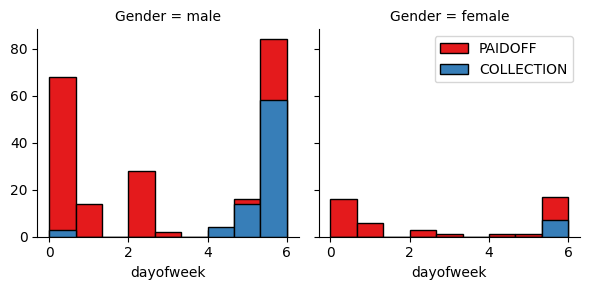

In [7]:
loan_data['dayofweek'] = loan_data['effective_date'].dt.dayofweek

bins = np.linspace(loan_data.dayofweek.min(), loan_data.dayofweek.max(), 10)
g = sns.FacetGrid(loan_data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

<b>We see that people who get the loan at the end of the week dont pay it off, so we will create new feature named weekend take values 0s and 1s </b>

In [8]:
loan_data['weekend'] = loan_data['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
loan_data.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


# Searching for other relations 

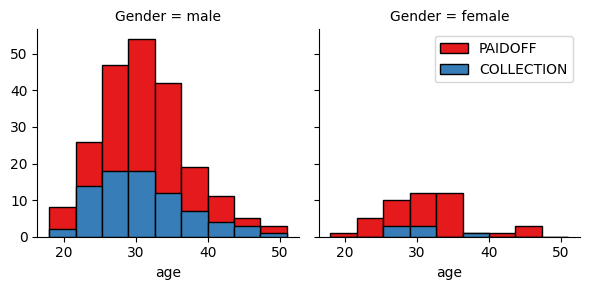

In [9]:
# Define bins with 10 evenly spaced intervals between the minimum and maximum age values
bins = np.linspace(loan_data.age.min(), loan_data.age.max(), 10)

# Create a FacetGrid with seaborn, arranging plots by 'Gender' column and using 'loan_status' for hue
# Set palette to 'Set1' for color consistency and col_wrap to 2 for 2 columns per row
g = sns.FacetGrid(loan_data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)

# Map histograms to each subplot of the FacetGrid, using 'age' as the variable to plot
# Specify the bins to be used for the histogram and set edge color to black ('k')
g.map(plt.hist, 'age', bins=bins, ec="k")

# Add legend to the last subplot
g.axes[-1].legend()

# Show the plot
plt.show()


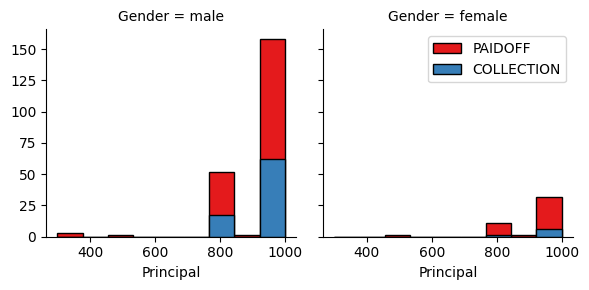

In [10]:
# Define bins with 10 evenly spaced intervals between the minimum and maximum principal values
bins = np.linspace(loan_data.Principal.min(), loan_data.Principal.max(), 10)

# Create a FacetGrid with seaborn, arranging plots by 'Gender' column and using 'loan_status' for hue
# Set palette to 'Set1' for color consistency and col_wrap to 2 for 2 columns per row
g = sns.FacetGrid(loan_data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)

# Map histograms to each subplot of the FacetGrid, using 'Principal' as the variable to plot
# Specify the bins to be used for the histogram and set edge color to black ('k')
g.map(plt.hist, 'Principal', bins=bins, ec="k")

# Add legend to the last subplot
g.axes[-1].legend()

# Show the plot
plt.show()


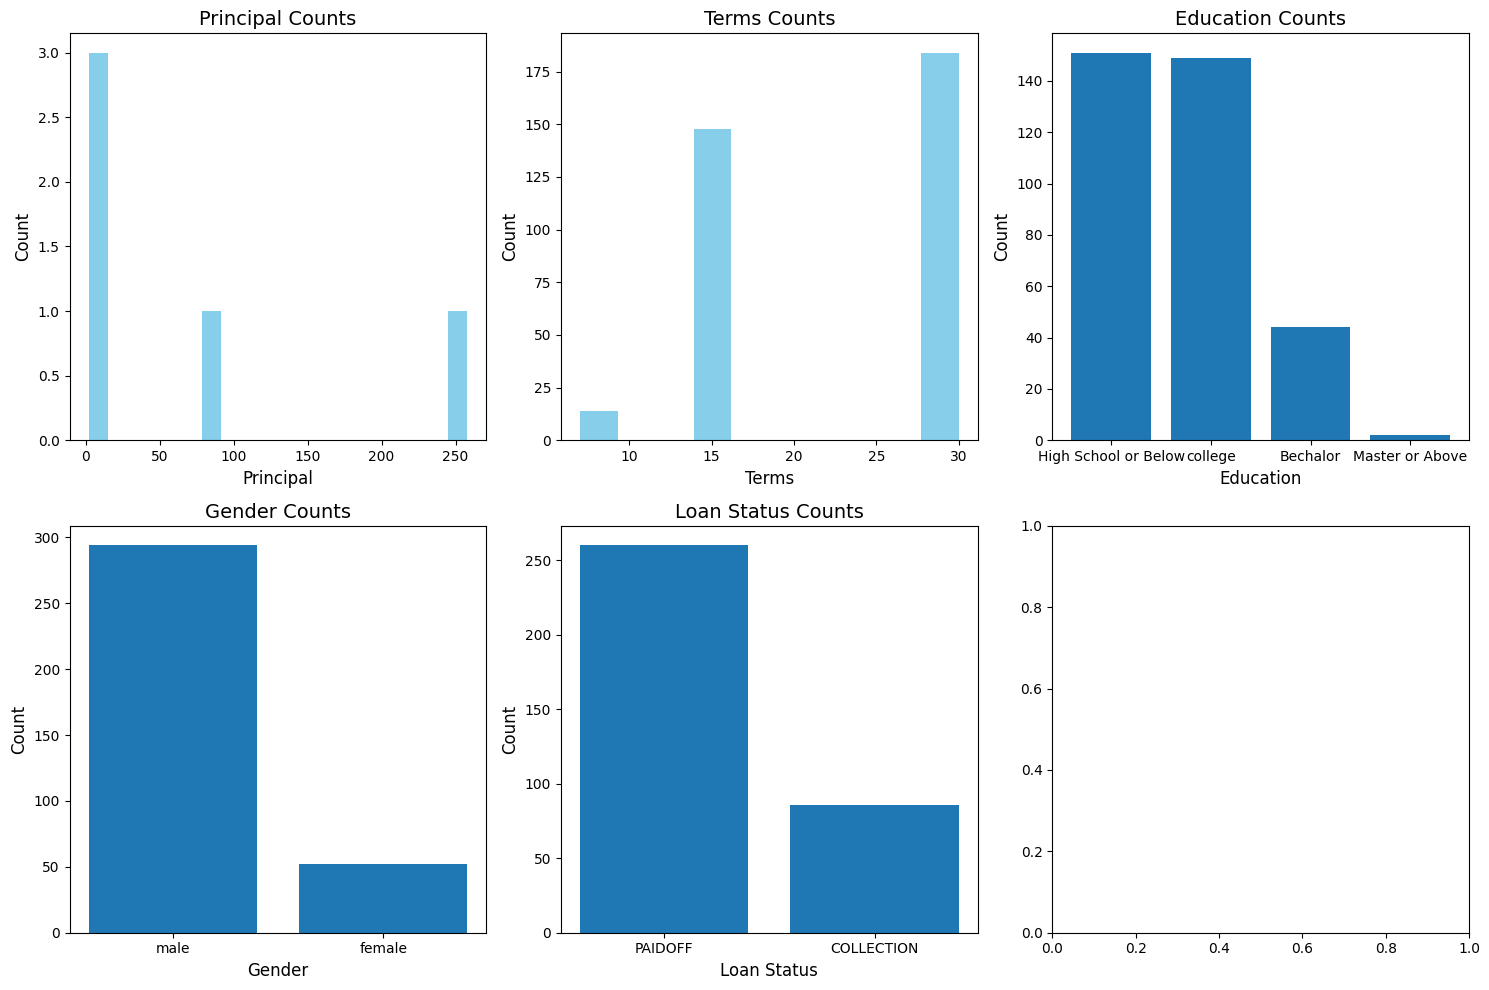

In [11]:
loan_status_counts = loan_data['loan_status'].value_counts()
principal_counts = loan_data['Principal'].value_counts()
terms_counts = loan_data['terms'].value_counts()
effective_date_counts = loan_data['effective_date'].value_counts()
due_date_counts = loan_data['due_date'].value_counts()
age_counts = loan_data['age'].value_counts()
education_counts = loan_data['education'].value_counts()
gender_counts = loan_data['Gender'].value_counts()
dayofweek_counts = loan_data['dayofweek'].value_counts()
weekend_counts = loan_data['weekend'].value_counts()

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot Principal counts
axs[0, 0].hist(principal_counts, bins=20, color='skyblue')
axs[0, 0].set_title('Principal Counts', fontsize=14)
axs[0, 0].set_xlabel('Principal', fontsize=12)
axs[0, 0].set_ylabel('Count', fontsize=12)

# Plot Terms counts
axs[0, 1].hist(loan_data['terms'], bins=10, color='skyblue')
axs[0, 1].set_title('Terms Counts', fontsize=14)
axs[0, 1].set_xlabel('Terms', fontsize=12)
axs[0, 1].set_ylabel('Count', fontsize=12)

# Plot Education counts
axs[0, 2].bar(education_counts.index, education_counts.values)
axs[0, 2].set_title('Education Counts', fontsize=14)
axs[0, 2].set_xlabel('Education', fontsize=12)
axs[0, 2].set_ylabel('Count', fontsize=12)

# Plot Gender counts
axs[1, 0].bar(gender_counts.index, gender_counts.values)
axs[1, 0].set_title('Gender Counts', fontsize=14)
axs[1, 0].set_xlabel('Gender', fontsize=12)
axs[1, 0].set_ylabel('Count', fontsize=12)

# Plot Loan Status counts
axs[1, 1].bar(loan_status_counts.index, loan_status_counts.values)
axs[1, 1].set_title('Loan Status Counts', fontsize=14)
axs[1, 1].set_xlabel('Loan Status', fontsize=12)
axs[1, 1].set_ylabel('Count', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


<h2> <b> Convert 'Gender' & 'loan_status' column to binary encoding </b></h2>

In [12]:
loan_data['Gender'] = loan_data['Gender'].map({'male': 1, 'female': 0})
# Convert 'loan_status' column to binary encoding
loan_data['loan_status'] = loan_data['loan_status'].map({'PAIDOFF': 1, 'COLLECTION': 0})
loan_data

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,1,3,0
1,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,0,3,0
2,1,1000,15,2016-09-08,2016-09-22,27,college,1,3,0
3,1,1000,30,2016-09-09,2016-10-08,28,college,0,4,1
4,1,1000,30,2016-09-09,2016-10-08,29,college,1,4,1
...,...,...,...,...,...,...,...,...,...,...
341,0,800,15,2016-09-11,2016-09-25,32,High School or Below,1,6,1
342,0,1000,30,2016-09-11,2016-10-10,25,High School or Below,1,6,1
343,0,800,15,2016-09-12,2016-09-26,39,college,1,0,0
344,0,1000,30,2016-09-12,2016-11-10,28,college,1,0,0


<h2> <b> Perform one-hot encoding for 'education' column </b></h2>

In [13]:
education_encoded = pd.get_dummies(loan_data['education'])

# Concatenate the encoded columns with the original DataFrame
loan_data = pd.concat([loan_data, education_encoded], axis=1)

# Drop the original 'education' column as it's no longer needed
loan_data.drop('education', axis=1, inplace=True)

loan_data['Bechalor'] = loan_data['Bechalor'].astype(int)
loan_data['High School or Below'] = loan_data['High School or Below'].astype(int)
loan_data['Master or Above'] = loan_data['Master or Above'].astype(int)
loan_data['college'] = loan_data['college'].astype(int)

loan_data

,loan_status,Principal,terms,effective_date,due_date,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,1,1000,30,2016-09-08,2016-10-07,45,1,3,0,0,1,0,0
1,1,1000,30,2016-09-08,2016-10-07,33,0,3,0,1,0,0,0
2,1,1000,15,2016-09-08,2016-09-22,27,1,3,0,0,0,0,1
3,1,1000,30,2016-09-09,2016-10-08,28,0,4,1,0,0,0,1
4,1,1000,30,2016-09-09,2016-10-08,29,1,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0,800,15,2016-09-11,2016-09-25,32,1,6,1,0,1,0,0
342,0,1000,30,2016-09-11,2016-10-10,25,1,6,1,0,1,0,0
343,0,800,15,2016-09-12,2016-09-26,39,1,0,0,0,0,0,1
344,0,1000,30,2016-09-12,2016-11-10,28,1,0,0,0,0,0,1


<h2><b>Calculate the difference in days between effective_date and due_date and insert them in loan_term_days ,  dropping effective_date and due_date </b></h2>

In [14]:
# Calculate the difference in days between effective_date and due_date
loan_data['loan_term_days'] = (loan_data['due_date'] - loan_data['effective_date']).dt.days

# Drop the original date columns if no longer needed
loan_data.drop(columns=['effective_date', 'due_date'], inplace=True)

# Display the modified DataFrame with the new feature
loan_data

,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college,loan_term_days
0,1,1000,30,45,1,3,0,0,1,0,0,29
1,1,1000,30,33,0,3,0,1,0,0,0,29
2,1,1000,15,27,1,3,0,0,0,0,1,14
3,1,1000,30,28,0,4,1,0,0,0,1,29
4,1,1000,30,29,1,4,1,0,0,0,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...
341,0,800,15,32,1,6,1,0,1,0,0,14
342,0,1000,30,25,1,6,1,0,1,0,0,29
343,0,800,15,39,1,0,0,0,0,0,1,14
344,0,1000,30,28,1,0,0,0,0,0,1,59


In [15]:
loan_data2=loan_data.copy()

<h2><b>Normalization using minmax scaler </b></h2>

In [16]:
# Select numerical columns for normalization
numerical_cols = ['Principal', 'terms', 'age','loan_term_days']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
loan_data[numerical_cols] = scaler.fit_transform(loan_data[numerical_cols])

# Display the normalized DataFrame
loan_data

,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college,loan_term_days
0,1,1.000000,1.000000,0.818182,1,3,0,0,1,0,0,0.433962
1,1,1.000000,1.000000,0.454545,0,3,0,1,0,0,0,0.433962
2,1,1.000000,0.347826,0.272727,1,3,0,0,0,0,1,0.150943
3,1,1.000000,1.000000,0.303030,0,4,1,0,0,0,1,0.433962
4,1,1.000000,1.000000,0.333333,1,4,1,0,0,0,1,0.433962
...,...,...,...,...,...,...,...,...,...,...,...,...
341,0,0.714286,0.347826,0.424242,1,6,1,0,1,0,0,0.150943
342,0,1.000000,1.000000,0.212121,1,6,1,0,1,0,0,0.433962
343,0,0.714286,0.347826,0.636364,1,0,0,0,0,0,1,0.150943
344,0,1.000000,1.000000,0.303030,1,0,0,0,0,0,1,1.000000


<h2><b>Outliers detection</b></h2>

In [17]:
# Select numerical columns for outlier detection
numerical_cols = ['Principal', 'terms', 'age','loan_term_days']

# Detect outliers for each numerical column
outliers = pd.DataFrame()

for col in numerical_cols:
    Q1 = loan_data[col].quantile(0.25)
    Q3 = loan_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    outlier_mask = (loan_data[col] < lower_threshold) | (loan_data[col] > upper_threshold)
    outliers[col] = outlier_mask
    
# Count outliers for each numerical column
outlier_counts = outliers.sum()

# Display the count of outliers for each numerical column
print(outlier_counts)

Principal          5
terms              0
age                5
loan_term_days    12
dtype: int64


<h3><b>Box plot to see the outliers</b></h3>

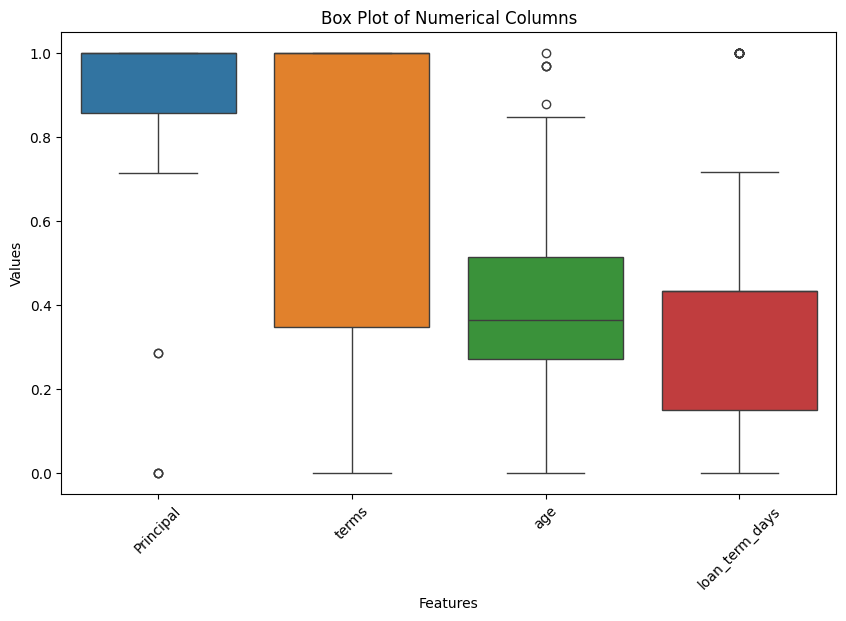

In [18]:
# Create box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=loan_data[numerical_cols])
plt.title('Box Plot of Numerical Columns')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

<h3><b>Outliers removal</b></h3>

In [19]:
loan_data = loan_data[~outliers.any(axis=1)]
loan_data

,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college,loan_term_days
0,1,1.000000,1.000000,0.818182,1,3,0,0,1,0,0,0.433962
1,1,1.000000,1.000000,0.454545,0,3,0,1,0,0,0,0.433962
2,1,1.000000,0.347826,0.272727,1,3,0,0,0,0,1,0.150943
3,1,1.000000,1.000000,0.303030,0,4,1,0,0,0,1,0.433962
4,1,1.000000,1.000000,0.333333,1,4,1,0,0,0,1,0.433962
...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,1.000000,1.000000,0.333333,0,6,1,0,0,0,1,0.433962
341,0,0.714286,0.347826,0.424242,1,6,1,0,1,0,0,0.150943
342,0,1.000000,1.000000,0.212121,1,6,1,0,1,0,0,0.433962
343,0,0.714286,0.347826,0.636364,1,0,0,0,0,0,1,0.150943


<h2><b>Checking for null values </b></h2>

In [20]:
loan_data.isnull().sum()

loan_status             0
Principal               0
terms                   0
age                     0
Gender                  0
dayofweek               0
weekend                 0
Bechalor                0
High School or Below    0
Master or Above         0
college                 0
loan_term_days          0
dtype: int64

<h2><b>Correlation matrix </b></h2>

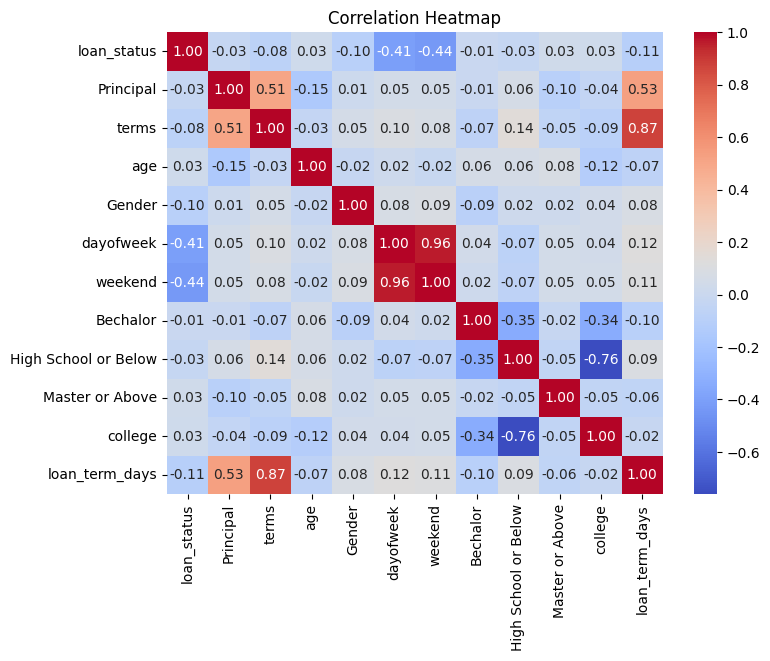

In [21]:
# Calculate correlation matrix
corr_matrix = loan_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

<b> we can see that there is high correlation between terms and loan_term_days of 0.87 ,, Duplicate Information: If 'loan_term_days' is highly correlated with 'terms' and provides essentially the same information but in a different unit of measure, keeping both columns may introduce redundancy to your dataset 

In [22]:
loan_data.drop(columns=['loan_term_days'], inplace=True)


In [23]:
loan_data

,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,1,1.000000,1.000000,0.818182,1,3,0,0,1,0,0
1,1,1.000000,1.000000,0.454545,0,3,0,1,0,0,0
2,1,1.000000,0.347826,0.272727,1,3,0,0,0,0,1
3,1,1.000000,1.000000,0.303030,0,4,1,0,0,0,1
4,1,1.000000,1.000000,0.333333,1,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
339,0,1.000000,1.000000,0.333333,0,6,1,0,0,0,1
341,0,0.714286,0.347826,0.424242,1,6,1,0,1,0,0
342,0,1.000000,1.000000,0.212121,1,6,1,0,1,0,0
343,0,0.714286,0.347826,0.636364,1,0,0,0,0,0,1


<h2><b>Bar plots </b></h2>

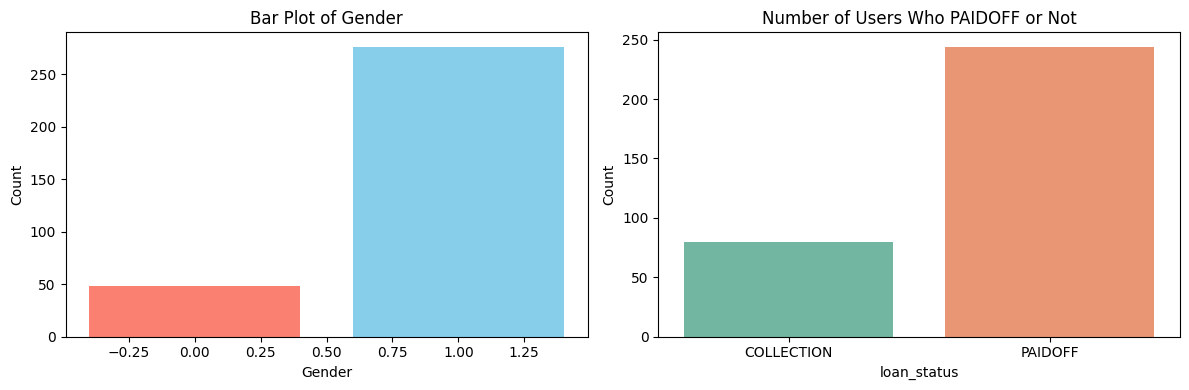

loan_status
1    244
0     80
Name: count, dtype: int64
Minority class ratio to majority class: 0.33


In [24]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Bar plot for Gender
axs[0].bar(loan_data['Gender'].value_counts().index, loan_data['Gender'].value_counts().values, color=['skyblue', 'salmon'])
axs[0].set_title('Bar Plot of Gender')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Count')

# Plot 2: Bar plot for loan_status
PAIDOFF_counts = loan_data['loan_status'].value_counts()
sns.barplot(x=PAIDOFF_counts.index, y=PAIDOFF_counts.values, palette='Set2', ax=axs[1])
axs[1].set_xlabel('loan_status')
axs[1].set_ylabel('Count')
axs[1].set_title('Number of Users Who PAIDOFF or Not')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['COLLECTION', 'PAIDOFF'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print class distribution and minority class ratio
class_distribution = loan_data['loan_status'].value_counts()
print(class_distribution)
class_ratio = class_distribution.min() / class_distribution.max()
print(f"Minority class ratio to majority class: {class_ratio:.2f}")

<b> Males are more than females alot <br>
<b> PAIDOFF are more than COLLECTION alot so data is unbalanced<b>

In [25]:
class_ratio = class_distribution.min() / class_distribution.max()
print(f"Minority class ratio to majority class: {class_ratio:.2f}")

Minority class ratio to majority class: 0.33


<h2><b>Balancing data with oversampling </b></h2>

<b> Oversampling involves increasing the number of instances in the minority class to match the number of instances in the majority class. In this case, the minority class is the class with 'loan_status' equal to 0 (presumably representing some form of loan default or non-payment), while the majority class is the class with 'loan_status' equal to 1 (presumably representing successful loan repayment)</b>

In [26]:
# Separate majority and minority classes
majority_class = loan_data[loan_data['loan_status'] == 1]
minority_class = loan_data[loan_data['loan_status'] == 0]

# Perform oversampling on the minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match majority class size
                              random_state=42)  # Seed for reproducibility

# Combine the oversampled minority class with the majority class
balanced_data = pd.concat([majority_class, minority_upsampled])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("After oversampling, the balanced data class distribution is:")
print(balanced_data['loan_status'].value_counts())


After oversampling, the balanced data class distribution is:
loan_status
1    244
0    244
Name: count, dtype: int64


In [27]:
balanced_data

,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,1,0.714286,0.347826,0.606061,1,6,1,0,1,0,0
1,0,1.000000,1.000000,0.272727,0,6,1,0,1,0,0
2,0,0.714286,0.347826,0.424242,1,5,1,0,0,0,1
3,1,0.714286,0.347826,0.606061,1,6,1,0,0,0,1
4,0,1.000000,1.000000,0.393939,1,6,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
483,1,1.000000,0.347826,0.242424,1,6,1,0,1,0,0
484,0,1.000000,1.000000,0.242424,1,0,0,0,0,0,1
485,0,1.000000,1.000000,0.151515,1,6,1,0,1,0,0
486,0,0.714286,0.347826,0.515152,1,6,1,0,1,0,0


# Phase 1 Models

## 1) Naive Bayes Classifier

In [28]:
X = balanced_data.drop(columns=['loan_status'])
y = balanced_data['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Create a Gaussian Naive Bayes classifier
nb_clf = GaussianNB()

# Train the classifier
nb_clf.fit(X_train, y_train)

GaussianNB()

In [30]:
# Compute training accuracy
train_accuracy = nb_clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.7666666666666667


In [31]:
# Make predictions
y_pred_nb = nb_clf.predict(X_test)

# Evaluate the model
print("Naive Bayes Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classifier Performance:
Accuracy: 0.6836734693877551
Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        44
           1       1.00      0.43      0.60        54

    accuracy                           0.68        98
   macro avg       0.79      0.71      0.67        98
weighted avg       0.81      0.68      0.66        98



### Confusion matrix for the NB classifier 

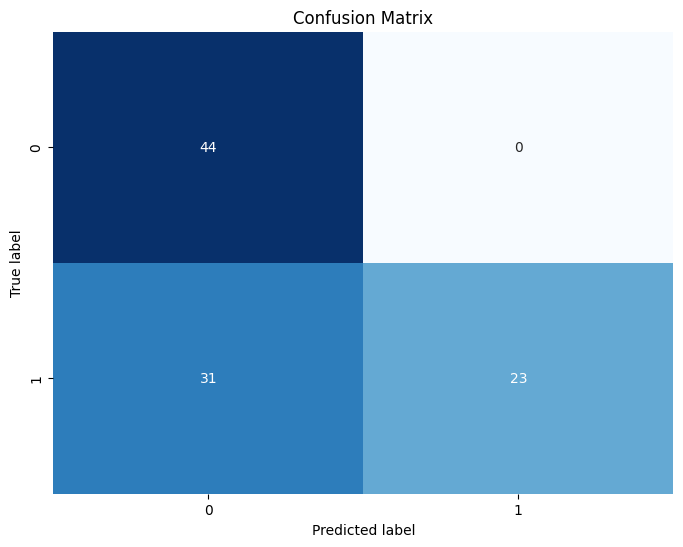

In [32]:
# Assuming y_test and y_pred are the true labels and predictions from the model
cm = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

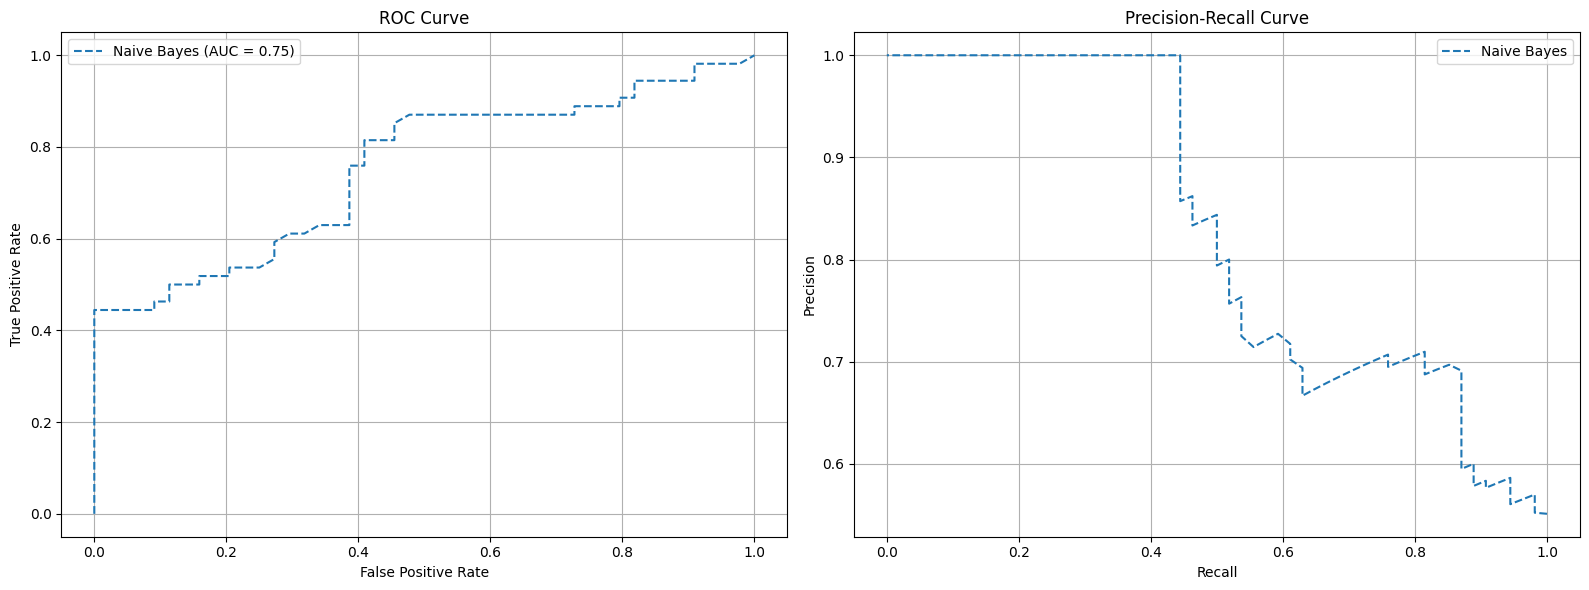

In [33]:
# Make predictions on the test set to get prediction probabilities
y_pred_prob_nb = nb_clf.predict_proba(X_test)
y_pred_nb = y_pred_prob_nb[:, 1]  # Probability of positive class

# Calculate ROC curve and AUC for Naive Bayes
nb_fpr, nb_tpr, _ = roc_curve(y_test, y_pred_nb)
nb_auc = roc_auc_score(y_test, y_pred_nb)

# Calculate Precision-Recall curve for Naive Bayes
nb_precision, nb_recall, _ = precision_recall_curve(y_test, y_pred_nb)  # Use y_pred_nb instead of y_pred_prob_nb

# Plot ROC curve and AUC
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(nb_fpr, nb_tpr, linestyle='--', label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(nb_recall, nb_precision, linestyle='--', label='Naive Bayes')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


---------------

### Grid search for NB

In [34]:
# Define the parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Create a Gaussian Naive Bayes classifier
nb_clf = GaussianNB()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=nb_clf, param_grid=param_grid, cv=7, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Train the model with the best parameters
best_estimator.fit(X_train, y_train)

Best Parameters: {'var_smoothing': 1e-09}


GaussianNB()

In [35]:
# Predicting labels for the training data
y_pred_train = best_estimator.predict(X_train)

# Calculating training accuracy
training_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.7666666666666667


In [36]:
# Predict on the test dataset
y_pred = best_estimator.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.6836734693877551
Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        44
           1       1.00      0.43      0.60        54

    accuracy                           0.68        98
   macro avg       0.79      0.71      0.67        98
weighted avg       0.81      0.68      0.66        98



<b> The same classification report  </b> 

-----------
----------



## 2. K-Nearest Neighbors Classifier


In [37]:
X = balanced_data.drop(columns=['loan_status'])
y = balanced_data['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

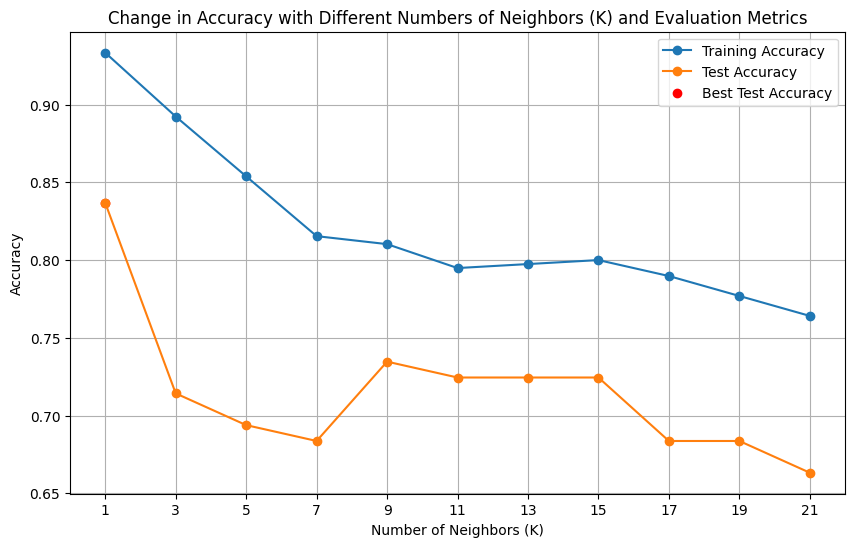

Best KNN Model Evaluation Metrics:
Best K Value: 1
Best Test Accuracy: 0.8367346938775511
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        44
           1       0.91      0.78      0.84        54

    accuracy                           0.84        98
   macro avg       0.84      0.84      0.84        98
weighted avg       0.85      0.84      0.84        98



In [38]:
# Define a range of odd k values for KNN
k_values = range(1, 22, 2)  # Try odd values from 1 to 33 neighbors

# Initialize lists to store accuracy scores
knn_accuracies_train = []
knn_accuracies_test = []
y_pred_knn_list = []

# Iterate over different k values and calculate accuracy for each
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict on the training set
    knn_train_preds = knn.predict(X_train)
    accuracy_train = accuracy_score(y_train, knn_train_preds)
    knn_accuracies_train.append(accuracy_train)
    
    # Predict on the test set
    knn_preds = knn.predict(X_test)
    accuracy_test = accuracy_score(y_test, knn_preds)
    knn_accuracies_test.append(accuracy_test)
    
    y_pred_knn_list.append(knn_preds)

# Plot the change in accuracy with different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies_train, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(k_values, knn_accuracies_test, marker='o', linestyle='-', label='Test Accuracy')

# Add evaluation metrics for the best KNN model
best_k_idx = np.argmax(knn_accuracies_test)
best_k = k_values[best_k_idx]
best_accuracy = knn_accuracies_test[best_k_idx]
best_classification_report = classification_report(y_test, y_pred_knn_list[best_k_idx])

# Plot best test accuracy value
plt.scatter(best_k, best_accuracy, color='red', label='Best Test Accuracy')

plt.title('Change in Accuracy with Different Numbers of Neighbors (K) and Evaluation Metrics')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics for the best KNN model
print("Best KNN Model Evaluation Metrics:")
print("Best K Value:", best_k)
print("Best Test Accuracy:", best_accuracy)
print("Classification Report:")
print(best_classification_report)

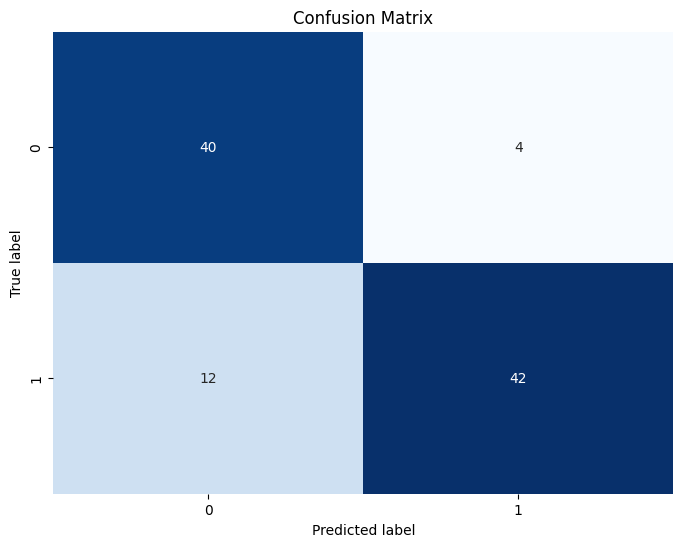

In [39]:
# Compute confusion matrix for the best KNN model
cm = confusion_matrix(y_test, y_pred_knn_list[best_k_idx])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

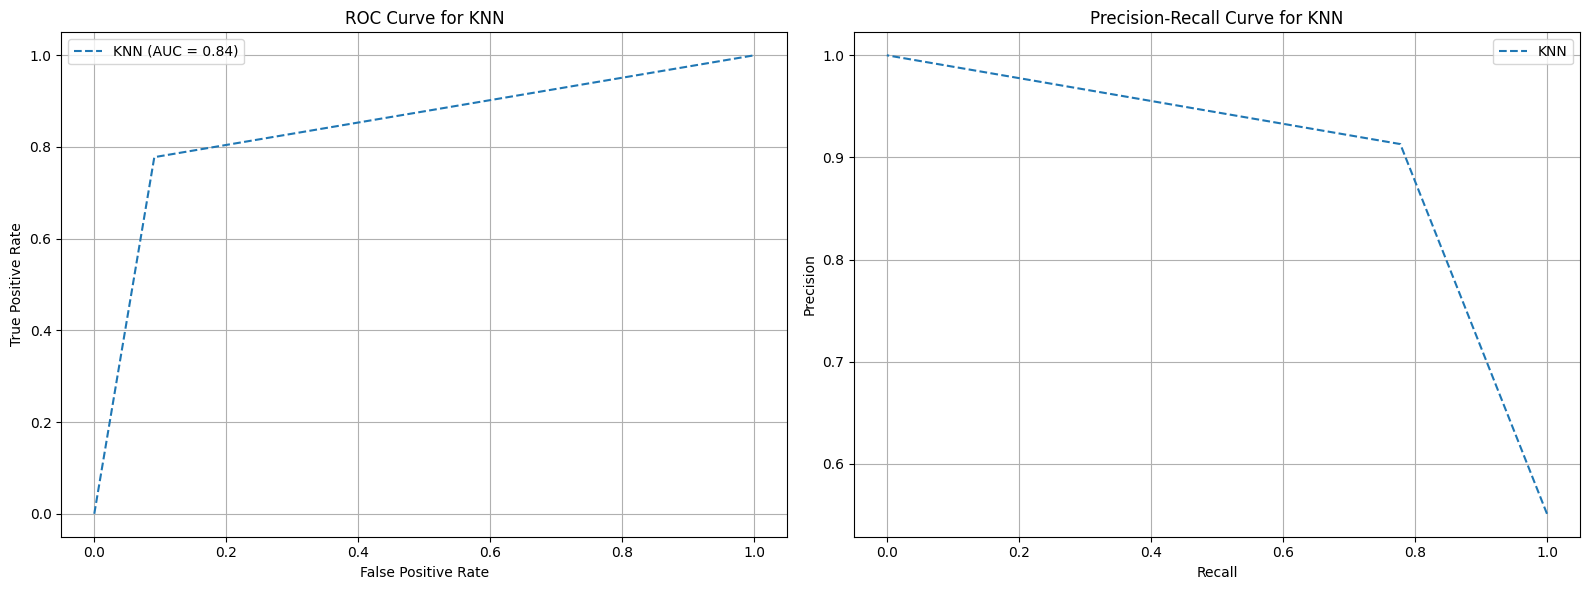

In [40]:
knn_clf_best = KNeighborsClassifier(n_neighbors=best_k)
knn_clf_best.fit(X_train, y_train)

# Calculate probabilities for KNN
knn_probs = knn_clf_best.predict_proba(X_test)[:, 1]


# Calculate ROC curve and AUC for KNN
# Assuming y_pred_knn_list contains predicted probabilities
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_auc = roc_auc_score(y_test, knn_probs)

# Plot ROC curve for KNN
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(knn_fpr, knn_tpr, linestyle='--', label=f'KNN (AUC = {knn_auc:.2f})')
plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

# Precision-Recall curve for KNN
knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn_probs)

plt.subplot(1, 2, 2)
plt.plot(knn_recall, knn_precision, linestyle='--', label='KNN')
plt.title('Precision-Recall Curve for KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Grid search for KNN 

In [41]:
# Define the parameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Create the KNN classifier
knn_clf = KNeighborsClassifier()

# Create the grid search object
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy')

# Train the grid search object (this will try all combinations of parameters)
grid_search.fit(X_train, y_train)

# Get the best parameters found during the grid search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model found during the grid search
best_knn_clf = grid_search.best_estimator_

# Make predictions with the best model
y_pred_knn = best_knn_clf.predict(X_test)

# Generate and print the classification report
classification_rep = classification_report(y_test, y_pred_knn)
print("Classification Report:")
print(classification_rep)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        44
           1       0.98      0.74      0.84        54

    accuracy                           0.85        98
   macro avg       0.86      0.86      0.85        98
weighted avg       0.88      0.85      0.85        98



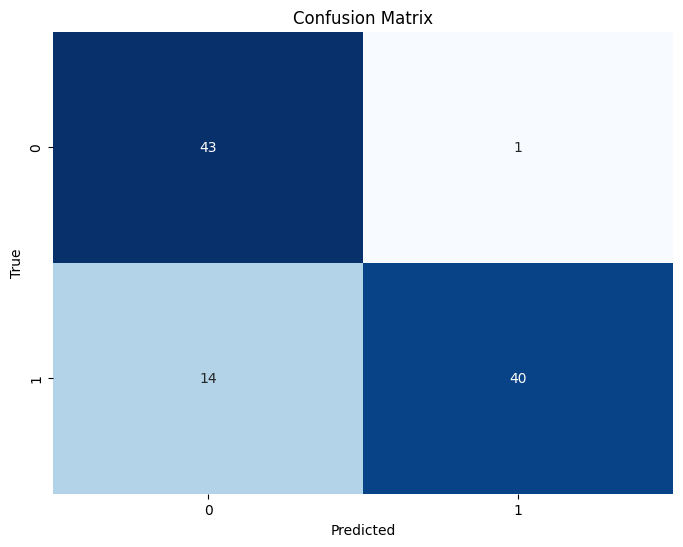

In [42]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

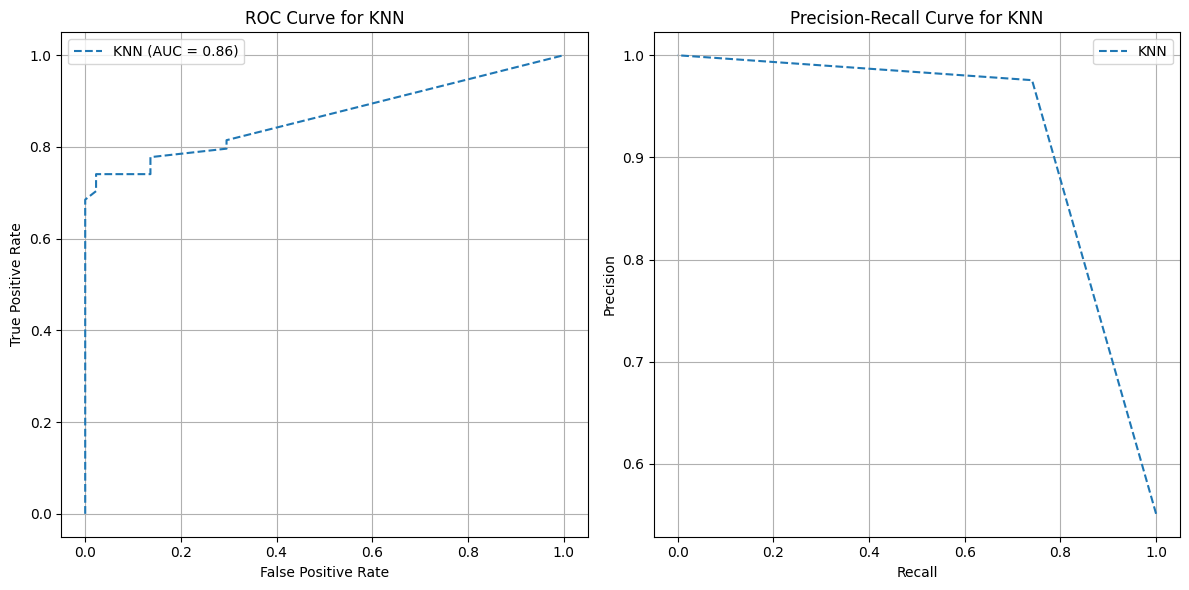

In [43]:
# Instantiate and train KNN classifier with the best k
knn_clf_best = KNeighborsClassifier(**best_params)
knn_clf_best.fit(X_train, y_train)

# Calculate probabilities for KNN
knn_probs = knn_clf_best.predict_proba(X_test)[:, 1]

knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_auc = roc_auc_score(y_test, knn_probs)

# Plot ROC curve for KNN
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(knn_fpr, knn_tpr, linestyle='--', label=f'KNN (AUC = {knn_auc:.2f})')

plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

# Precision-Recall curve for KNN
knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_pred_knn)

plt.subplot(1, 2, 2)
plt.plot(knn_recall, knn_precision, linestyle='--', label='KNN')
plt.title('Precision-Recall Curve for KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Phase 2

## Decision Tree

<b>I have went through multiple approaches when dealing with the dataset after applying all the required encoding :<br><br></b>
1-I have applied the DT classifier on the dataset which has (outliers removed ,normalization,removal of loan_term_days,balanced train ,unbalanced dataset) gives accuracy 58% and 62  after grid search  <br><br> 
2-I have applied the DT classifier on the dataset which has (no outliers removal,normalization,removal of loan_term_days,balanced train and not balanced dataset)     gives>>63 % and 67% after gridsearch <br><br>
3-I have applied the DT classifier on the dataset which has (no outliers removal,normalization,removal of loan_term_days,not balanced dataset) >>> gives 67% and the same for gridearch <br><br>
4-I have applied the DT classifier on the dataset which has (outliers removed,normalization,removal of loan_term_days, balanced dataset,) >>> gives 88% and same for grid search <br>
so from all these trials ,, i will stick to no 4 in the following steps 

In [44]:
# Split the data into features (X) and target variable (y)
X =balanced_data.drop('loan_status', axis=1)
y =balanced_data['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the decision tree classifier on the 'Purchased' column
clf.fit(X_train, y_train)
# Predict on the testing set
y_pred = clf.predict(X_test)



In [46]:
# Compute training accuracy
train_accuracy = clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9564102564102565


In [47]:
# Generate classification report
report = classification_report(y_test, y_pred)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 
# Print the classification report
print("Classification Report:")
print(report)

Accuracy: 0.8877551020408163
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        44
           1       1.00      0.80      0.89        54

    accuracy                           0.89        98
   macro avg       0.90      0.90      0.89        98
weighted avg       0.91      0.89      0.89        98



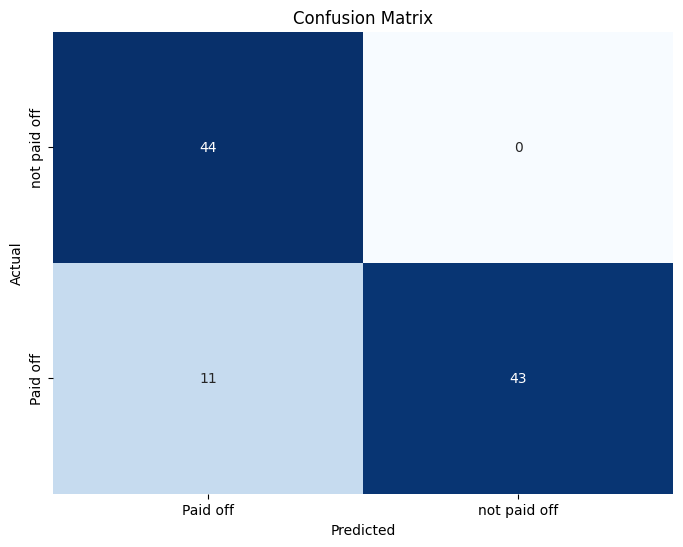

In [48]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0.5, 1.5], labels=['Paid off', 'not paid off'])
plt.yticks(ticks=[0.5, 1.5], labels=['not paid off', 'Paid off'])

plt.show()

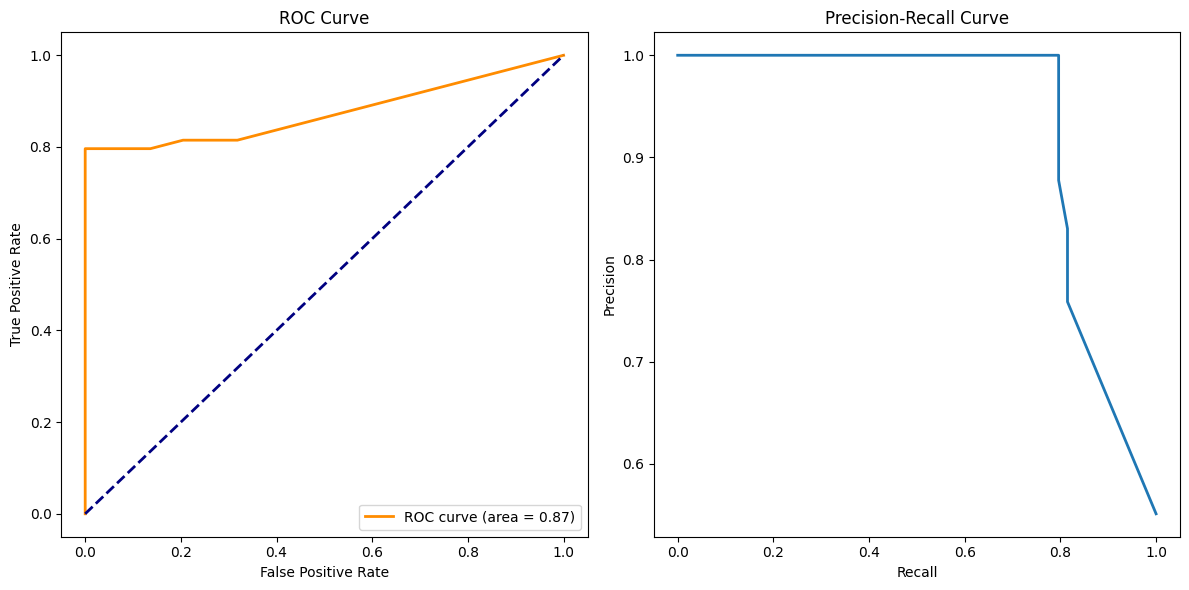

In [49]:
# Calculate ROC curve
# For ROC curve
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate Precision-Recall curve
# Since DecisionTreeClassifier doesn't have a decision_function method, we'll use predict_proba directly
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve and Precision-Recall curve side by side
plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall curve plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


### GridSearch HyperParamter tuning

In [50]:
# Define the parameter grid
param_grid = {
    'max_depth': [ 5,10, 20, 30,40,50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10,15],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4,5]      # Minimum number of samples required to be at a leaf node
}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=7, scoring='accuracy', verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Predict on the testing set with the best estimator
y_pred = best_clf.predict(X_test)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(report)

Fitting 7 folds for each of 96 candidates, totalling 672 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8877551020408163
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        44
           1       1.00      0.80      0.89        54

    accuracy                           0.89        98
   macro avg       0.90      0.90      0.89        98
weighted avg       0.91      0.89      0.89        98



<b> Same accuracy without gridsearch <b>

_____
___

## Multilayer Perceptron

In [51]:
# Split the data into features (X) and target variable (y)
X = balanced_data.drop('loan_status', axis=1)
y = balanced_data['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', solver='adam',random_state=42)

# Train the classifier
mlp.fit(X_train, y_train)

# Predict on the testing set
y_pred = mlp.predict(X_test)


In [53]:
# Compute training accuracy
train_accuracy = mlp.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.823076923076923


In [54]:
# Generate classification report
report = classification_report(y_test, y_pred)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 
# Print the classification report
print("Classification Report:")
print(report)

Accuracy: 0.7448979591836735
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77        44
           1       0.94      0.57      0.71        54

    accuracy                           0.74        98
   macro avg       0.79      0.76      0.74        98
weighted avg       0.81      0.74      0.74        98



### Confusion matrix for MLP

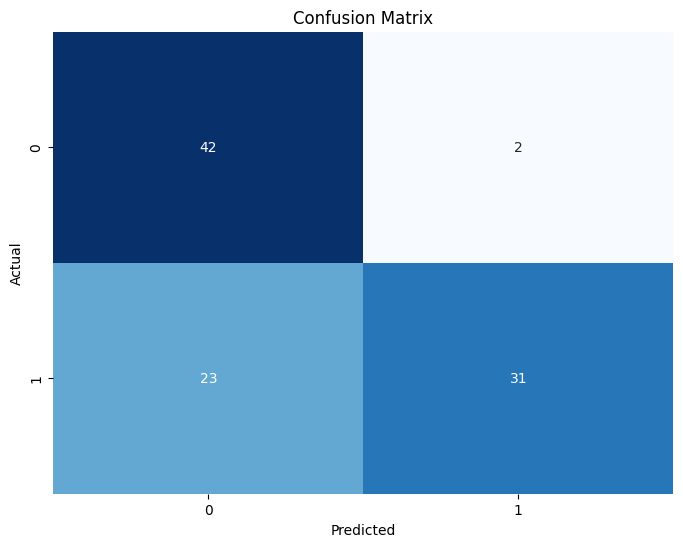

In [55]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

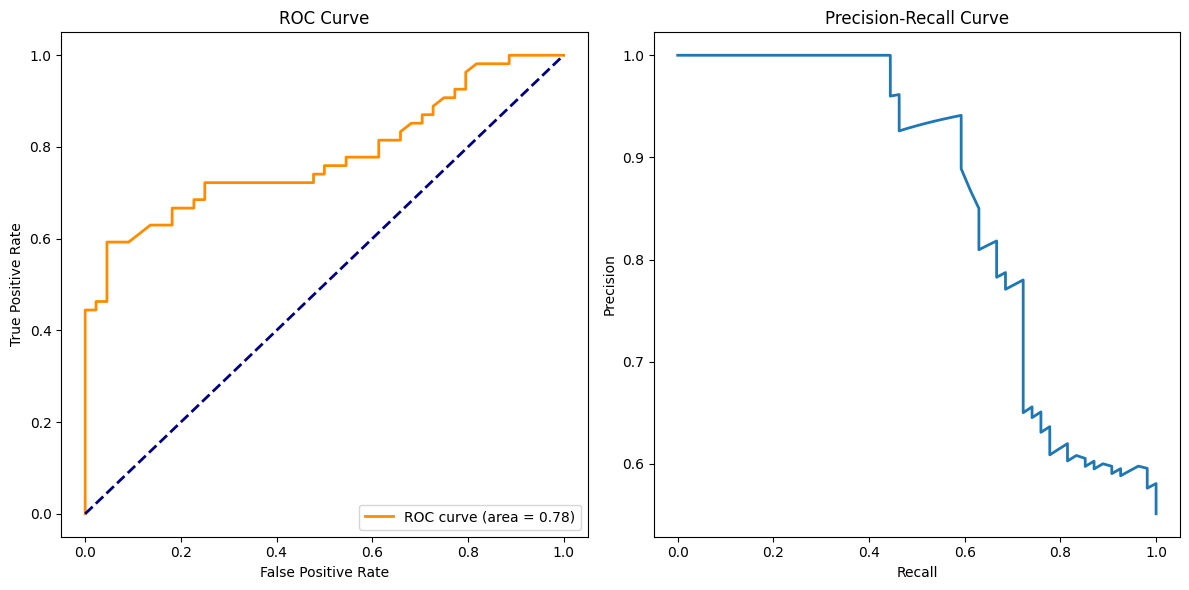

In [56]:
# Calculate ROC curve
y_pred_prob = mlp.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve and Precision-Recall curve side by side
plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall curve plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

### Hyperparameter Tuning

In [57]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(64, 64), (128, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64]
}

# Initialize the MLP classifier
mlp = MLPClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Train the model with the best parameters
best_estimator.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}


MLPClassifier(batch_size=32, hidden_layer_sizes=(128, 128), random_state=42)

In [58]:
# Compute training accuracy
train_accuracy = best_estimator.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.8307692307692308


In [59]:
# Predict on the test dataset
y_pred = best_estimator.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.7346938775510204
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75        44
           1       0.85      0.63      0.72        54

    accuracy                           0.73        98
   macro avg       0.75      0.75      0.73        98
weighted avg       0.76      0.73      0.73        98



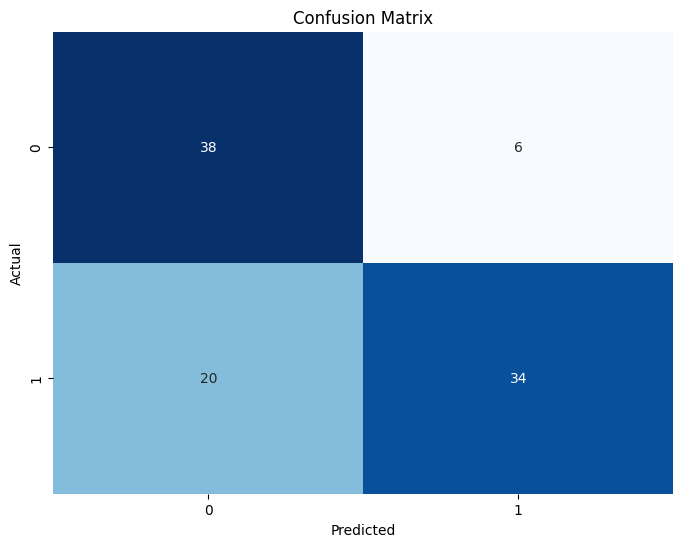

In [60]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

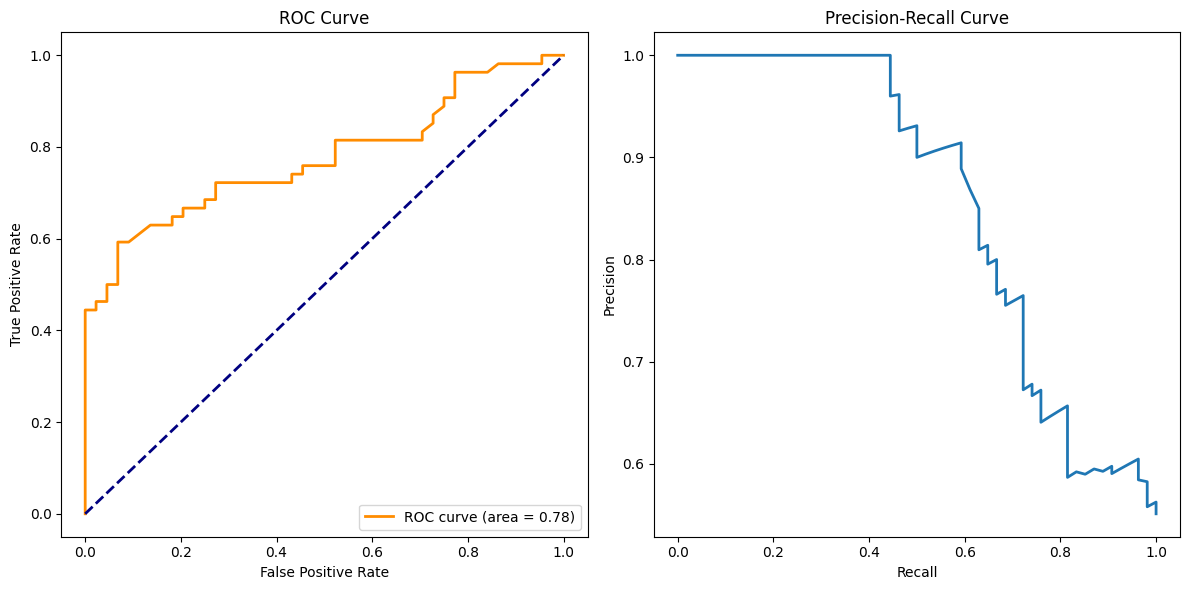

In [61]:
# Calculate ROC curve
y_pred_prob = best_estimator.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve and Precision-Recall curve side by side
plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall curve plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## SVM 

In [62]:
# Split the data into features (X) and target variable (y)
X = balanced_data.drop('loan_status', axis=1)
y = balanced_data['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Initialize the SVM classifier
svm_classifier = SVC(C=10,kernel='poly',gamma=1, random_state=42)  # Linear kernel for simplicity, you can try other kernels as well

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm_classifier.predict(X_test)

In [64]:
# Compute training accuracy
train_accuracy = svm_classifier.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.8384615384615385


In [65]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7448979591836735
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77        44
           1       0.94      0.57      0.71        54

    accuracy                           0.74        98
   macro avg       0.79      0.76      0.74        98
weighted avg       0.81      0.74      0.74        98



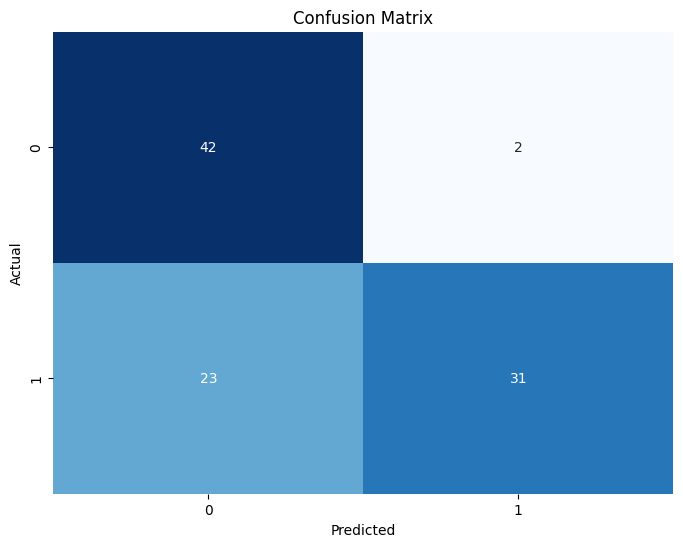

In [66]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

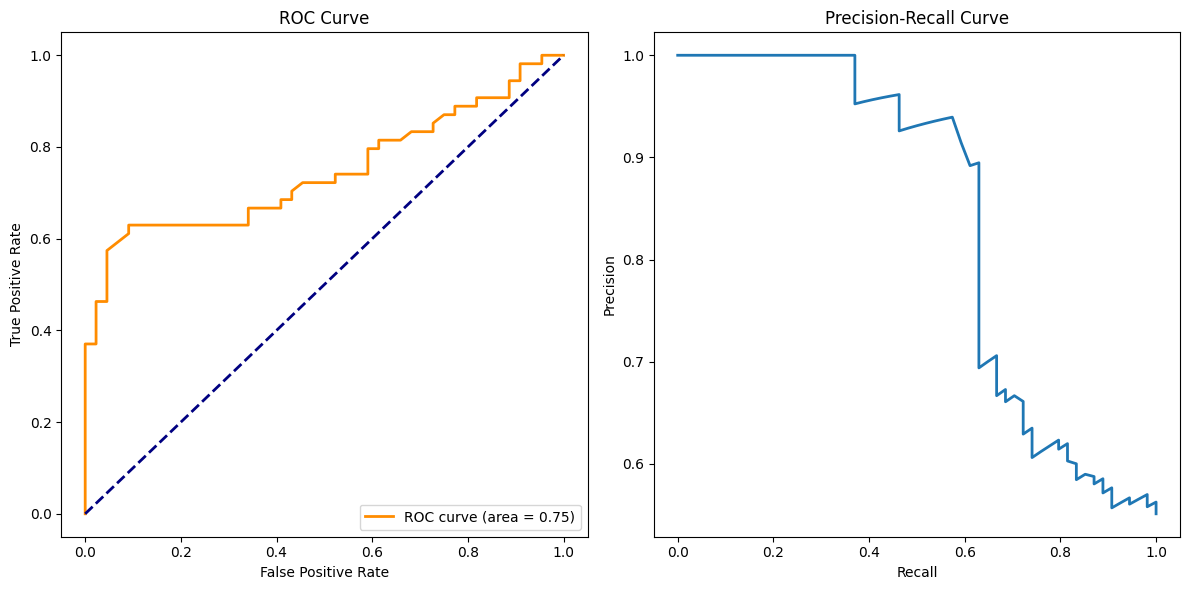

In [67]:
# Compute predicted probabilities for the positive class
y_pred_prob = svm_classifier.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve and Precision-Recall curve
plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall curve plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

### SVM hyperparameter tuning

In [68]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf','poly'],  # Kernel type
    'gamma': [0.1, 1, 10, 100]  # Kernel coefficient for 'rbf' kernel
}

# Initialize the SVM classifier
svm_classifier = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Train the model with the best parameters
best_estimator.fit(X_train, y_train)

# Predict on the testing set
y_pred = best_estimator.predict(X_test)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 100, 'gamma': 100, 'kernel': 'rbf'}


In [69]:
# Compute training accuracy
train_accuracy = best_estimator.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9538461538461539


In [70]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8469387755102041
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.85        44
           1       0.95      0.76      0.85        54

    accuracy                           0.85        98
   macro avg       0.86      0.86      0.85        98
weighted avg       0.87      0.85      0.85        98



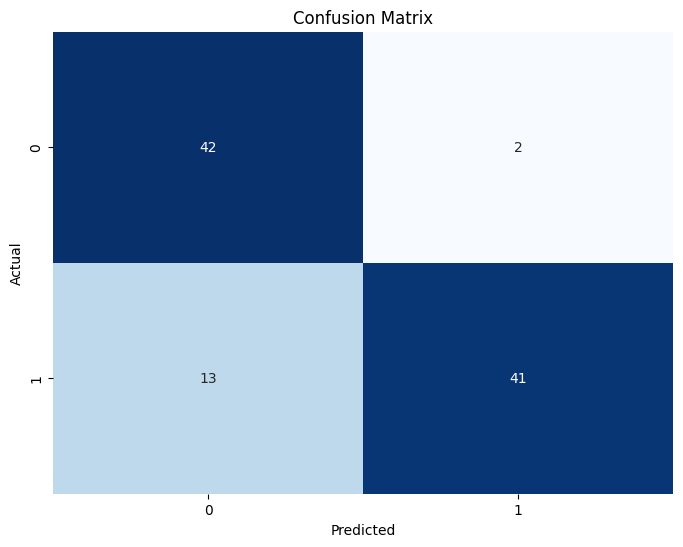

In [71]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

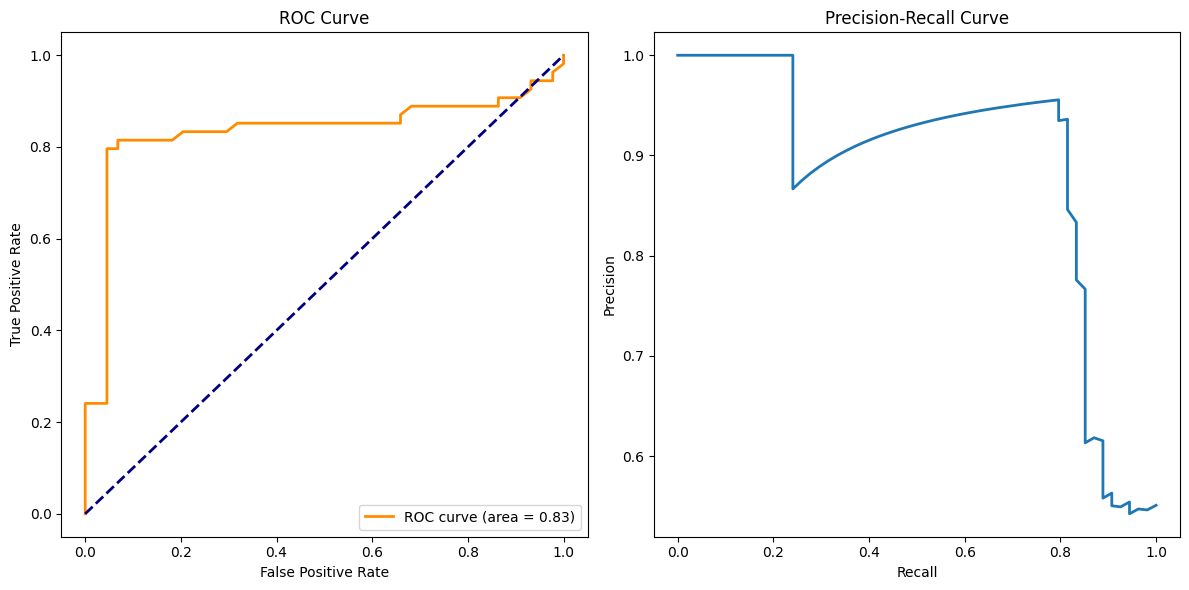

In [72]:
# Compute predicted probabilities for the positive class
y_pred_prob = best_estimator.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve and Precision-Recall curve
plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall curve plot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()